In [1]:
import os
import numpy as np
from hdf5storage import loadmat, savemat
from numpy import random
import numpy as np
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gamma, norm
from scipy.stats import multivariate_normal as mvn
from numpy.random import default_rng
from sklearn.linear_model import LinearRegression

Load data

In [2]:
#load 
kn= loadmat('results/runB/kn_1_2_allneg_60_6_4.mat')
kn.keys()

dict_keys(['capacity', 'distribution_table', 'items', 'js_div_list', 'max_no_improve_gen', 'n_con', 'n_items', 'n_obj', 'n_selected', 'pareto_front_final', 'pareto_indices_final', 'pop_size', 'r', 'r_con', 'r_obj', 'rpos', 'scale', 'shape'])

Get useful variables 

In [3]:
n_con = kn['n_con'] #number of constraints
n_items = kn['n_items'] #number of items
n_obj = kn['n_obj'] #number of objectives
n_selected = kn['n_selected'] #number of selected items#get useful variables 
pf = kn['pareto_front_final'] #final paretkedin.com/o front
pi = kn['pareto_indices_final'] #final pareto indices
dt = kn['distribution_table'] #distribution table
items = kn['items'] #item features - objectives and constraints 
n_run = len(items) # number of runs for a set of parameters 


This function transforms any set of items to the normal space.  This is going to be used many times  

In [4]:
def transform_items_to_z(items):
    alpha = np.empty(items.shape[1])
    beta = np.empty(items.shape[1])
    items_z = np.empty(items.shape)
    for i in range(items.shape[1]):#get useful variables 
        a, loc, scale = gamma.fit(items[:, i], floc=0.0)
        alpha[i] = a
        beta[i] = scale
        u = gamma.cdf(items[:,i], a = a, scale = scale)
        u = np.clip(u, 1e-12, 1-1e-12)
        items_z[:,i] = norm.ppf(u) 
    return alpha, beta,items_z

For each of the runs, transform the items to the normal space as items_z and compute the correlation matrix between 

In [5]:
shape = np.empty((n_run,n_obj+n_con))
scale = np.empty((n_run,n_obj+n_con))
items_z = list()
r_items = np.empty((n_run,n_obj+n_con,n_obj+n_con))
for j in range(len(items)):
    items_r = kn['items'][j]
    items_r = items_r+1
    a,b,z = transform_items_to_z(items_r)
    shape[j,:] = a
    scale[j,:] = b
    items_z.append(z)
    r_items[j,:,:]= np.corrcoef(np.transpose(z))

<Axes: >

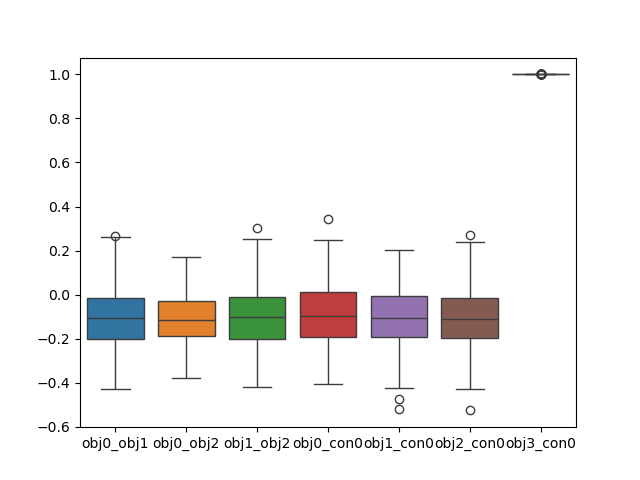

In [6]:
import pandas as pd
corrdf = pd.DataFrame()
for j in range(n_obj):
    for k in range(j+1,3):
        corrdf[f"obj{j}_obj{k}"] = r_items[:,j,k]
for j in range(n_obj):
        corrdf[f"obj{j}_con0"] = r_items[:,j,3]
plt.figure()
sns.boxplot(corrdf)        

In [7]:
print(kn['r_con'])
print(kn['r_obj'])

0.2
0.1


In [8]:
print(kn['rpos'][0])

[[ 1.  -0.1 -0.1 -0.1  0.2]
 [-0.1  1.  -0.1 -0.1  0.2]
 [-0.1 -0.1  1.  -0.1  0.2]
 [-0.1 -0.1 -0.1  1.   0.2]
 [ 0.2  0.2  0.2  0.2  1. ]]


In [9]:
rng = default_rng(seed = 1111)
XX_z_list = []
YY_list = []
for j in range(len(pi)):
    px = pi[j]
    XX = np.empty((px.shape[0],n_selected,n_obj+n_con))
    XX_z = np.empty((px.shape[0],n_selected,n_obj+n_con))
    for k in range(px.shape[0]): 
        qx = rng.permutation(px[k,:])
        XX_z[k,:,:] = items_z[j][qx,:]
        XX[k,:,:] = items[j][qx,:]
    YY = np.cumsum(XX,axis = 1)
    XX_z_list.append(XX_z)
    YY_list.append(YY)

In [10]:
# Convert to DataFrame long format for easy plotting
for n in range(len(YY_list)):
    rows = []
    for j in range(n_selected):
        for k in range(n_obj+n_con):
            if k < n_obj:
                rows.append(pd.DataFrame({
                    'cumulative': YY_list[n][:,j, k],
                    'step': f'Step {j}',
                    'objective': f'Obj {k}',
                    'run': n,
                }))
            else:
                rows.append(pd.DataFrame({
                    'cumulative': YY_list[n][:,j, k],
                    'step': f'Step {j}',
                    'objective': f'Con {k-n_obj}',
                    'run': n,
                }))
    df_Y = pd.concat(rows, ignore_index=True)
    

In [11]:
# Convert to DataFrame long format for easy plotting
for n in range(len(XX_z_list)):
    rows = []
    for j in range(n_selected):
        for k in range(n_obj+n_con):
            if k < n_obj:
                rows.append(pd.DataFrame({
                    'cumulative': XX_z_list[n][:, j, k],
                    'step': f'Step {j}',
                    'objective': f'Obj {k}',
                    'run': n
                }))
            else:
                rows.append(pd.DataFrame({
                    'cumulative': XX_z_list[n][:, j, k],
                    'step': f'Step {j}',
                    'objective': f'Con {k-n_obj}',
                    'run': n
                }))
    df_Xz = pd.concat(rows, ignore_index=True)
    

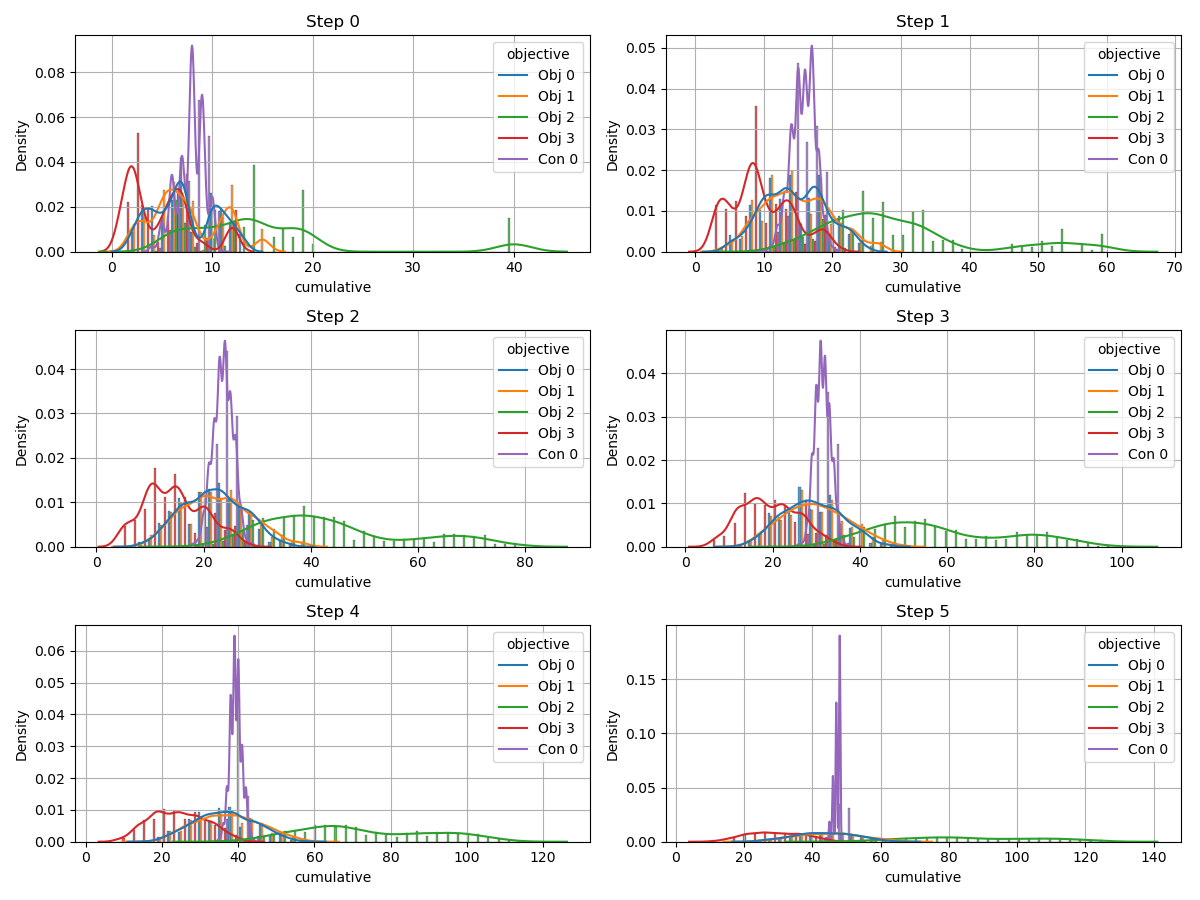

In [12]:
fig, axes = plt.subplots(3, int(n_selected/3), figsize=(12, 9))
axes = axes.ravel()

for j in range(n_selected):
    ax = axes[j]
    sns.histplot(
        data=df_Y[df_Y['step'] == f'Step {j}'],
        x='cumulative',
        hue='objective',
        element='bars',      # outline hist
        stat='density',
        common_bins=True,    # shared bins across 4 overlays
        bins=40,
        ax= ax,
        multiple = "dodge"
    )
    sns.kdeplot(
        data=df_Y[df_Y['step'] == f'Step {j}'],
        x='cumulative',
        hue='objective',
        ax=ax,
        common_norm=True
    )

    ax.set_title(f'Step {j}')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [13]:
def ecdf(df_table,n_selected,n_obj,n_con):
    nk = len(df_table)/(n_selected*(n_obj+n_con))
    ecdf_table = np.zeros((n_selected,(n_obj+n_con),int(nk)))
    for t in range(1,n_selected):
        for i in range(n_obj+n_con):
            if i < n_obj:
                ecdf_table[t,i,:] = np.sort(df_table['cumulative'][(df_table['objective'] == f'Obj {i}')&(df_table['step'] == f'Step {t}')].values)
            else:
                ecdf_table[t,i,:] = np.sort(df_table['cumulative'][(df_table['objective'] == f'Con {i - n_obj}')&(df_table['step'] == f'Step {t}')].values)
    return ecdf_table


def z_transform_from_ecdf(Y, ecdf_table):
    # assumes runs have been converted to data frame   
    N, d = Y.shape  
    Y_z = np.empty_like(Y)
    
    for t in range(1,N):
        for i in range(d):
            ranks = np.searchsorted(ecdf_table[t,i,:], Y[t, i], side='right')
            u = ranks / len(ecdf_table[t,i,:])
            u = np.clip(u, 1e-12, 1 - 1e-12)
            Y_z[t, i] = norm.ppf(u)
    return Y_z


In [14]:
ecdf_table = ecdf(df_Y,n_selected,n_obj,n_con)
YY_z_list = []# Convert to DataFrame long format for easy plotting
for j in range(len(YY_list)): 
    YY = YY_list[j]
    YY_z = np.empty_like(YY)
    for k in range(YY.shape[0]):
        YY_z[k] = z_transform_from_ecdf(YY[k],ecdf_table)
        YY_z[k,0,:] = XX_z_list[j][k,0,:]
    YY_z_list.append(YY_z)

In [15]:
# Convert to DataFrame long format for easy plotting
for n in range(len(YY_z_list)):
    rows = []
    for j in range(n_selected):
        for k in range(n_obj+n_con):
            if k < n_obj:
                rows.append(pd.DataFrame({
                    'cumulative': YY_z_list[n][:, j, k],
                    'step': f'Step {j}',
                    'objective': f'Obj {k}',
                    'run': n
                }))
            else:
                rows.append(pd.DataFrame({
                    'cumulative': YY_z_list[n][:, j, k],
                    'step': f'Step {j}',
                    'objective': f'Con {k-n_obj}',
                    'run': n
                }))
    df_Yz = pd.concat(rows, ignore_index=True)

### Markov in Y models 

In this section, we consider models of selection of items X that are Markov in Y.  That is, they have the property that the probability of selecting the next item in the Pareto set only depends on the current state of the knapsack Y (sum of objectives and constraints).  

In [16]:
def fit_markov_in_y(X, Y):
    K, N, d = X.shape
    S = Y[:, :-1, :].reshape(-1, d)   
    Z = X[:, 1:, :].reshape(-1, d)   
    reg = LinearRegression(fit_intercept=True)
    reg.fit(S, Z)
    A = reg.coef_        # note: use rows for ouutput
    b = reg.intercept_
    r2 = reg.score(S, Z)
    # Residual covariance Q
    Z_hat = reg.predict(S)
    R = Z - Z_hat                  
    Q = np.cov(R, rowvar=False, bias=False)
    return {"A": A, "b": b, "Q": Q,"reg": reg,"R2": r2}

def conditional_density_given_Y(X_candidates, y_normal,params):
    
    A = params["A"]   
    b = params["b"]   
    Q = params["Q"]   

    X_candidates = np.asarray(X_candidates)
    y_normal = np.asarray(y_normal).reshape(-1)

    mean = A @ y_normal + b 

    # Vectorized multivariate normal pdf
    densities = mvn.pdf(X_candidates,mean=mean,cov=Q)

    return densities
  

In [17]:
params_yz = fit_markov_in_y(np.vstack(XX_z_list[:160]),np.vstack(YY_z_list[:160]))
print("A:\n", params_yz["A"])
print("b:\n", params_yz["b"])
print("Q:\n", params_yz["Q"]) 
print("R2:", params_yz["R2"])

A:
 [[ 0.01139617 -0.01944816 -0.02443645 -0.01894689 -0.02712437]
 [-0.01651426  0.01424908 -0.01794926 -0.01341144 -0.02052703]
 [-0.01822415 -0.01733673  0.01885937 -0.01707569 -0.03386389]
 [-0.01846348 -0.02283572 -0.02153755  0.00672596 -0.03706343]
 [-0.00411089 -0.00726407 -0.0041814  -0.00651349 -0.15244072]]
b:
 [ 0.43210405  0.43415356  0.41641837  0.4147512  -0.06999896]
Q:
 [[ 1.32578551 -0.31457579 -0.2905691  -0.34016942  0.1120929 ]
 [-0.31457579  1.34043848 -0.32925644 -0.31421936  0.08385134]
 [-0.2905691  -0.32925644  1.3430537  -0.28817422  0.14227994]
 [-0.34016942 -0.31421936 -0.28817422  1.39419278  0.15654241]
 [ 0.1120929   0.08385134  0.14227994  0.15654241  0.63919042]]
R2: 0.03556164470958747


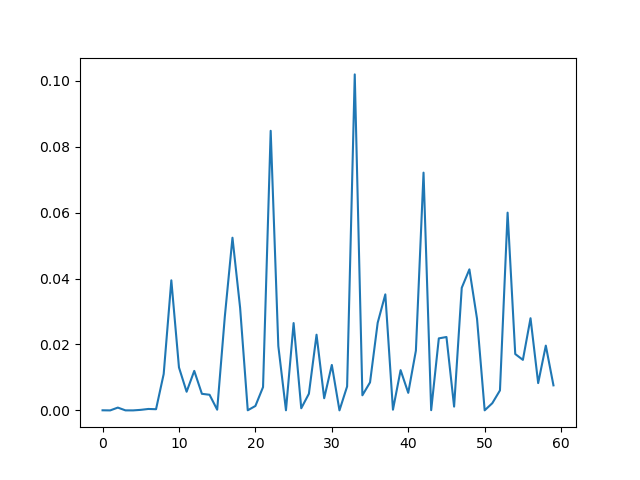

In [18]:
def base_rate_model(items_z,XX_0):
    mean0 = np.mean(XX_0,axis = 0)
    Sigma0 = np.cov(XX_0.T) #python is stupid
    mvn0 = mvn(mean=mean0, cov=Sigma0)
    x_candidates = items_z
    probabilities = mvn0.pdf(x_candidates)
    probabilities = (probabilities+1e-12)/sum(probabilities+1e-12)
    return probabilities
probabilities = base_rate_model(items_z[100],np.vstack(XX_z_list)[:,0,:])
plt.figure()
plt.plot(probabilities)


The R2 on that model is pretty poor, which makes sense since its unlikely the same linear model operates at the start of filling the knapsack as later.  So, here we make a version with a separate model for each step in filling the knapsack. 

In [19]:
def fit_markov_in_y_by_t(X, Y):
    K, N, d = X.shape

    A_list = np.zeros((N-1, d, d))
    b_list = np.zeros((N-1, d))
    Q_list = np.zeros((N-1, d, d))
    R2_list = np.zeros(N-1)
    reg_list = []

    for t in range(1, N):  
        S_t = Y[:, t-1, :]  
        Z_t = X[:, t,   :] 

        reg_t = LinearRegression(fit_intercept=True)
        reg_t.fit(S_t, Z_t)

        A_t = reg_t.coef_      # (d, d)
        b_t = reg_t.intercept_ # (d,)

        Z_hat_t = reg_t.predict(S_t)
        R_t = Z_t - Z_hat_t
        Q_t = np.cov(R_t, rowvar=False, bias=False)
        r2 = reg_t.score(S_t, Z_t)

        A_list[t-1, :, :] = A_t
        b_list[t-1, :] = b_t
        Q_list[t-1, :, :] = Q_t
        R2_list[t-1] = r2
        reg_list.append(reg_t)
    params = {"A": A_list,"b": b_list,"Q": Q_list,"regs": reg_list,"R2": R2_list}
    return params

params_yz_time = fit_markov_in_y_by_t(np.vstack(XX_z_list[0:160]), np.vstack(YY_z_list[0:160]))
print("A at time 5:\n", params_yz_time["A"][4])
print("b at time 5:\n", params_yz_time["b"][4])
print("Q at time 5:\n", params_yz_time["Q"][4]) 
print(params_yz_time["R2"])

A at time 5:
 [[ 0.01156563 -0.02921899 -0.03192099 -0.02445385 -0.04600993]
 [-0.02717214  0.01783079 -0.02263766 -0.01821809 -0.03479646]
 [-0.03608849 -0.03131392  0.00998178 -0.02550216 -0.05548671]
 [-0.03618221 -0.03761923 -0.03204988 -0.00030844 -0.05934253]
 [-0.03066914 -0.02721956 -0.02401878 -0.02390314 -0.24214978]]
b at time 5:
 [ 0.42409432  0.43024237  0.41025395  0.40312872 -0.12858868]
Q at time 5:
 [[ 1.31395733 -0.31881066 -0.30027944 -0.34782458  0.06903053]
 [-0.31881066  1.33535734 -0.34007311 -0.32226808  0.04912637]
 [-0.30027944 -0.34007311  1.33157524 -0.30445811  0.08632833]
 [-0.34782458 -0.32226808 -0.30445811  1.37635227  0.0983901 ]
 [ 0.06903053  0.04912637  0.08632833  0.0983901   0.41393901]]
[0.00620558 0.01548807 0.02939377 0.05350141 0.10228152]


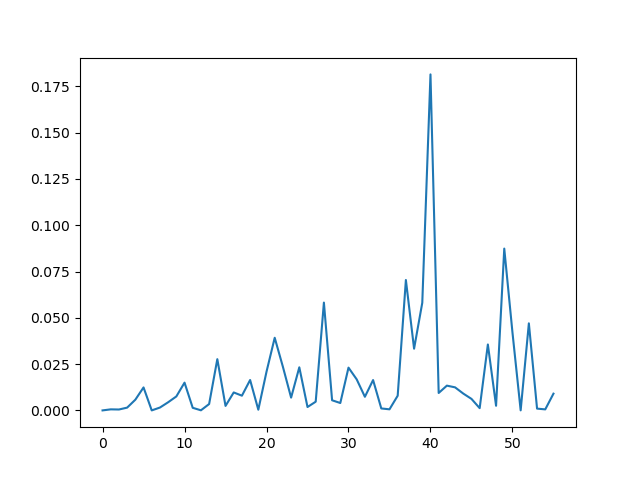

In [20]:
def conditional_density_given_Y_and_t(X_candidates, y_normal, params_time, t):
    A_all = params_time["A"]  
    b_all = params_time["b"]  
    Q_all = params_time["Q"]  

    A_t = A_all[t-1]
    b_t = b_all[t-1]
    Q_t = Q_all[t-1]
    X_candidates = np.asarray(X_candidates)
    y_normal = np.asarray(y_normal).reshape(-1)
    mean_t = A_t @ y_normal + b_t

    densities = mvn.pdf(X_candidates, mean=mean_t, cov=Q_t)
    return densities

# Example usage with multiple candidates
x_candidates = items_z[161][np.setdiff1d(np.arange(n_items),pi[161][100,0:4]),:]
y_prev = YY_z_list[161][100, 4, :]    # Y at step 4 of run 10
densities2 = conditional_density_given_Y_and_t(x_candidates, y_prev, params_yz_time, t=5)
plt.figure()
plt.plot(densities2/sum(densities2))
plt.show()

This is a little better but not compelling.  But worth checking how well it does to find the pareto front.  

In [21]:
def eval_knapsack(knapsack,pf_actual,n_obj,scale,shape):
    pf_predicted = np.sum(knapsack, axis=0)
    std_dev = np.sqrt(shape)*scale
    count = 0 
    pfdif = np.zeros(pf_actual.shape[0])
    for j in range(pf_actual.shape[0]):
        if np.any(pf_predicted[0:n_obj] > pf_actual[j,0:n_obj]):
            count = count + 1
        pfdif[j] = np.linalg.norm(pf_predicted[0:n_obj]/std_dev[0:n_obj] - pf_actual[j,0:n_obj]/std_dev[0:n_obj])
    pf_difference = np.min(pfdif) 
    domination_score = 1-count/pf_actual.shape[0]
    return domination_score, pf_difference


In [22]:
pf_difference = np.zeros(40)
domination_score = np.zeros(40)
for kk in range(40):
    k = kk+160
    probabilities = base_rate_model(items_z[k],np.vstack(XX_z_list[0:160])[:,0,:])
    knapsack_indices = np.zeros(n_selected,dtype=int)
    knapsack = np.zeros((n_selected,(n_obj+n_con)))
    first_choice = np.argmax(probabilities)
    first_item = items_z[k][first_choice,:]
    x_indices = np.setdiff1d(np.arange(n_items),knapsack_indices)
    y_prev = first_item 
    knapsack[0,:] = items[k][first_choice,:]
    knapsack_indices[0] = first_choice
    for n in range(1,n_selected):
        x_indices = np.setdiff1d(np.arange(n_items),knapsack_indices[0:n])
        x_candidates = items_z[k][x_indices,:]
        densities = conditional_density_given_Y_and_t(x_candidates, y_prev, params_yz_time, t=n)
        probabilities = densities/sum(densities)
        next_choice = np.argmax(probabilities)
        next_index = x_indices[next_choice]
        next_item = items_z[k][next_index,:]
        knapsack[n,:] = items[k][next_index,:]
        knapsack_indices[n] = next_index
        y_prev = y_prev + next_item
  
    pf_predicted = np.sum(knapsack, axis=0)
    pf_actual = pf[k]
    count = 0 
    domination_score[kk], pf_difference[kk] = eval_knapsack(knapsack,pf_actual,n_obj,kn['scale'],kn['shape'])


In [23]:
print(np.mean(domination_score))
print(np.mean(pf_difference))
print(np.sqrt(kn['shape'])*kn['scale'])

0.13055741724672068
3.660454445476128
[3.         3.46410162 6.         2.82842712 2.82842712]


Markov in Y with weighted samples. 

In [24]:
""" pf_weights = np.empty((0,))
for n in range(160):
    pfx = np.zeros((pf[n].shape[0],pf[n].shape[0]))
    for j in range(pf[n].shape[0]-1):
        for k in range(j+1,pf[n].shape[0]):
            pfx[j,k] = np.sum(pf[n][j,0:3] > pf[n][k,0:3])
            pfx[k,j] = np.sum(pf[n][j,0:3] < pf[n][k,0:3])
    pf_weights = np.concatenate((pf_weights,np.mean(pfx,axis=1))) """

' pf_weights = np.empty((0,))\nfor n in range(160):\n    pfx = np.zeros((pf[n].shape[0],pf[n].shape[0]))\n    for j in range(pf[n].shape[0]-1):\n        for k in range(j+1,pf[n].shape[0]):\n            pfx[j,k] = np.sum(pf[n][j,0:3] > pf[n][k,0:3])\n            pfx[k,j] = np.sum(pf[n][j,0:3] < pf[n][k,0:3])\n    pf_weights = np.concatenate((pf_weights,np.mean(pfx,axis=1))) '

In [25]:


""" def fit_markov_in_y_by_t(X, Y, weights):
    K, N, d = X.shape
    weights = np.asarray(weights).reshape(-1)


    A_list = np.zeros((N-1, d, d))
    b_list = np.zeros((N-1, d))
    Q_list = np.zeros((N-1, d, d))
    R2_list = np.zeros(N-1)
    reg_list = []

    w = weights / np.sum(weights)

    for t in range(1, N):
        S_t = Y[:, t-1, :]   
        Z_t = X[:, t,   :]   

        reg_t = LinearRegression(fit_intercept=True)
        reg_t.fit(S_t, Z_t, sample_weight=weights)   

        A_t = reg_t.coef_       
        b_t = reg_t.intercept_  

        Z_hat_t = reg_t.predict(S_t)
        R_t = Z_t - Z_hat_t     

        R_bar = np.sum(R_t * w[:, None], axis=0, keepdims=True)
        Rc = R_t - R_bar

        # Effective sample size for unbiased-ish normalization
        eff = 1.0 - np.sum(w**2)
        Q_t = (Rc.T * w) @ Rc / eff

        r2 = reg_t.score(S_t, Z_t, sample_weight=weights)

        A_list[t-1, :, :] = A_t
        b_list[t-1, :] = b_t
        Q_list[t-1, :, :] = Q_t
        R2_list[t-1] = r2
        reg_list.append(reg_t)

    params = {"A": A_list, "b": b_list, "Q": Q_list, "regs": reg_list, "R2": R2_list}
    return params
 """

' def fit_markov_in_y_by_t(X, Y, weights):\n    K, N, d = X.shape\n    weights = np.asarray(weights).reshape(-1)\n\n\n    A_list = np.zeros((N-1, d, d))\n    b_list = np.zeros((N-1, d))\n    Q_list = np.zeros((N-1, d, d))\n    R2_list = np.zeros(N-1)\n    reg_list = []\n\n    w = weights / np.sum(weights)\n\n    for t in range(1, N):\n        S_t = Y[:, t-1, :]   \n        Z_t = X[:, t,   :]   \n\n        reg_t = LinearRegression(fit_intercept=True)\n        reg_t.fit(S_t, Z_t, sample_weight=weights)   \n\n        A_t = reg_t.coef_       \n        b_t = reg_t.intercept_  \n\n        Z_hat_t = reg_t.predict(S_t)\n        R_t = Z_t - Z_hat_t     \n\n        R_bar = np.sum(R_t * w[:, None], axis=0, keepdims=True)\n        Rc = R_t - R_bar\n\n        # Effective sample size for unbiased-ish normalization\n        eff = 1.0 - np.sum(w**2)\n        Q_t = (Rc.T * w) @ Rc / eff\n\n        r2 = reg_t.score(S_t, Z_t, sample_weight=weights)\n\n        A_list[t-1, :, :] = A_t\n        b_list[t-1, 

In [26]:
print(kn['r'])
print(kn['rpos'][0])

[[ 1.  -0.1 -0.1 -0.1  0.2]
 [-0.1  1.  -0.1 -0.1  0.2]
 [-0.1 -0.1  1.  -0.1  0.2]
 [-0.1 -0.1 -0.1  1.   0.2]
 [ 0.2  0.2  0.2  0.2  1. ]]
[[ 1.  -0.1 -0.1 -0.1  0.2]
 [-0.1  1.  -0.1 -0.1  0.2]
 [-0.1 -0.1  1.  -0.1  0.2]
 [-0.1 -0.1 -0.1  1.   0.2]
 [ 0.2  0.2  0.2  0.2  1. ]]


In [27]:
""" pf_difference = np.zeros(40)
domination_score = np.zeros(40)
for kk in range(40):
    k = kk+160
    probabilities = base_rate_model(items_z[k],np.vstack(XX_z_list[0:160])[:,0,:])
    knapsack_indices = np.zeros(n_selected,dtype=int)
    knapsack = np.zeros((n_selected,(n_obj+n_con)))
    first_choice = np.argmax(probabilities)
    first_item = items_z[k][first_choice,:]
    x_indices = np.setdiff1d(np.arange(n_items),knapsack_indices)
    y_prev = first_item 
    knapsack[0,:] = items[k][first_choice,:]
    knapsack_indices[0] = first_choice
    for n in range(1,n_selected):
        x_indices = np.setdiff1d(np.arange(n_items),knapsack_indices[0:n])
        x_candidates = items_z[k][x_indices,:]
        densities = conditional_density_given_Y_and_t(x_candidates, y_prev, params_yz_time, t=n)
        probabilities = densities/sum(densities)
        next_choice = np.argmax(probabilities)
        next_index = x_indices[next_choice]
        next_item = items_z[k][next_index,:]
        knapsack[n,:] = items[k][next_index,:]
        knapsack_indices[n] = next_index
        y_prev = y_prev + next_item
  
    pf_predicted = np.sum(knapsack, axis=0)
    pf_actual = pf[k]
    domination_score[kk], pf_difference[kk] = eval_knapsack(knapsack,pf_actual,n_obj,kn['scale'],kn['shape'])

 """

" pf_difference = np.zeros(40)\ndomination_score = np.zeros(40)\nfor kk in range(40):\n    k = kk+160\n    probabilities = base_rate_model(items_z[k],np.vstack(XX_z_list[0:160])[:,0,:])\n    knapsack_indices = np.zeros(n_selected,dtype=int)\n    knapsack = np.zeros((n_selected,(n_obj+n_con)))\n    first_choice = np.argmax(probabilities)\n    first_item = items_z[k][first_choice,:]\n    x_indices = np.setdiff1d(np.arange(n_items),knapsack_indices)\n    y_prev = first_item \n    knapsack[0,:] = items[k][first_choice,:]\n    knapsack_indices[0] = first_choice\n    for n in range(1,n_selected):\n        x_indices = np.setdiff1d(np.arange(n_items),knapsack_indices[0:n])\n        x_candidates = items_z[k][x_indices,:]\n        densities = conditional_density_given_Y_and_t(x_candidates, y_prev, params_yz_time, t=n)\n        probabilities = densities/sum(densities)\n        next_choice = np.argmax(probabilities)\n        next_index = x_indices[next_choice]\n        next_item = items_z[k][next_

In [28]:
""" print(np.mean(domination_score))
print(np.mean(pf_difference)) """

' print(np.mean(domination_score))\nprint(np.mean(pf_difference)) '

In [29]:
""" print(kn['r'])
print(kn['rpos'][0]) """

" print(kn['r'])\nprint(kn['rpos'][0]) "